# Uso de AutoCodificadores imagenes - reducción de dimensiones

## Los Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_entreno, y_entreno), (X_prueba, y_prueba) = mnist.load_data()

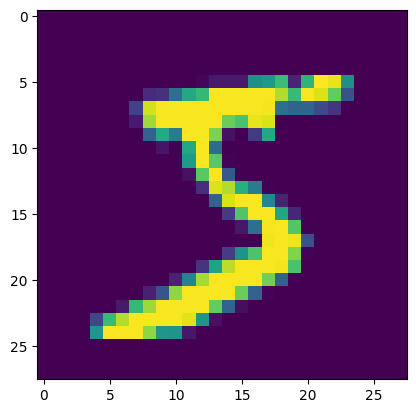

In [4]:
plt.imshow(X_entreno[0])

### Se normalizan los datos (escala original 0 - 255)

In [5]:
X_entreno = X_entreno/255
X_prueba = X_prueba/255

## AutoCodificador Básico

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape
# from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.legacy import SGD #para uso con procesadores M! y M2

Es buena idea armar lo que se llama un "AutoCodificador Apilado" en el cual cada capa va rebajando el número de neuronas hasta el número que desee. 

Esto es principalmente para que el aprendizaje pueda ser más escalonado y no intentar que sea de un solo golpe.

Para este ejercicio se irá bajando aproximadamente de mitad en mitad, hasta llegar a una capa de tan solo 25 neuronas.

Esto es totalmente arbitrario y pueden escogerse otros esquémas

In [7]:
784/2

392.0

In [8]:
codificador = Sequential()
codificador.add(Flatten(input_shape = [28, 28]))
codificador.add(Dense(400, activation = "relu"))
codificador.add(Dense(200, activation = "relu"))
codificador.add(Dense(100, activation = "relu"))
codificador.add(Dense(50, activation = "relu"))
codificador.add(Dense(25, activation = "relu"))

La capa final de codificador es de 25 unidades,  El decodificador toma esa como entrada y va aumentando hasta llegar a la dimensión correcta.

Como se desea comparar con la imagen original, es necesario regresar al formato original de 28 X 28

In [9]:
decodificador = Sequential()
decodificador.add(Dense(50, input_shape = [25],
                        activation = 'relu'))
decodificador.add(Dense(100, activation = 'relu'))
decodificador.add(Dense(200, activation = 'relu'))
decodificador.add(Dense(400, activation = 'relu'))
decodificador.add(Dense(784, activation = "sigmoid"))
decodificador.add(Reshape([28, 28]))

### Conformar el autocodificador completo.

Se utiliza la función de activación *sigmoid* porque usaremos la función de pérdida *binary_crossenthropy*

Se utilza la función de pérdida *binary_crossenthropy* porque no interesa obtener clases sino conocer si la imagen resultante es similar a la original.

In [10]:
autocodificador = Sequential([codificador, 
                              decodificador])
autocodificador.compile(loss = "binary_crossentropy", optimizer = SGD(learning_rate = 1.5), metrics = ['accuracy'])

In [11]:
autocodificador.fit(X_entreno, X_entreno, 
                    epochs = 5,
                    validation_data = [X_prueba, 
                                       X_prueba])

Epoch 1/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2491 - accuracy: 0.0879 - val_loss: 0.2132 - val_accuracy: 0.1146
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1919 - accuracy: 0.1482 - val_loss: 0.1704 - val_accuracy: 0.1781
Epoch 3/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.1653 - accuracy: 0.1887 - val_loss: 0.1561 - val_accuracy: 0.1995
Epoch 4/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.1529 - accuracy: 0.2065 - val_loss: 0.1449 - val_accuracy: 0.2150
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1446 - accuracy: 0.2173 - val_loss: 0.1423 - val_accuracy: 0.2158


Ver si el autocodificador puede predecir (en este caso, reconstruir) las imágenes que recibe

In [12]:
imagenes_generadas = autocodificador.predict(X_prueba[:10])

1/1 [==============================] - 0s 91ms/step


Imagen original


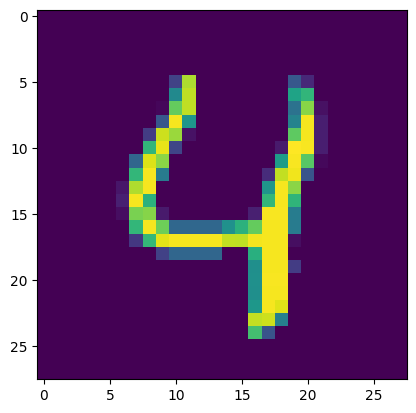

Imagen reconstruida con el autocodificador


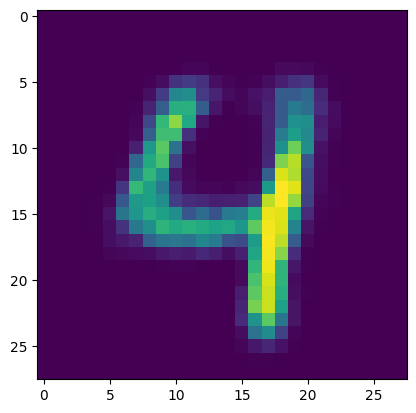

In [13]:
n = 4   # Seleccionar la imagen que se desea comparar

print("Imagen original")
plt.imshow(X_prueba[n]);
plt.show()
print("Imagen reconstruida con el autocodificador")
plt.imshow(imagenes_generadas[n]);

Para probar con otra imagen...ejecutar celda anterior con otro valor de n.

Bastante impresionante...se redujeron las dimensiones de 28 X 28 = 784 a tan solo 25, o sea solo el 3% de las dimensiones originales, y se lograron imágenes bastante parecidas!

# AutoCodificadores para reducir el ruido en imágenes

In [14]:
from tensorflow.keras.layers import GaussianNoise

### Ver cómo funciona el generador de ruido

In [15]:
muestra = GaussianNoise(0.2)   # Desviación estándard, si se quiere más ruido, incrementar

In [16]:
ruidosas = muestra(X_prueba[:10], training = True)

Imagen original


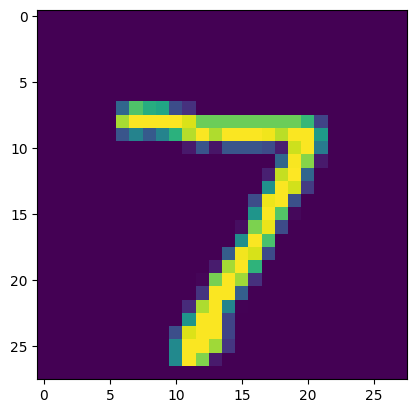

Imagen ruidosa


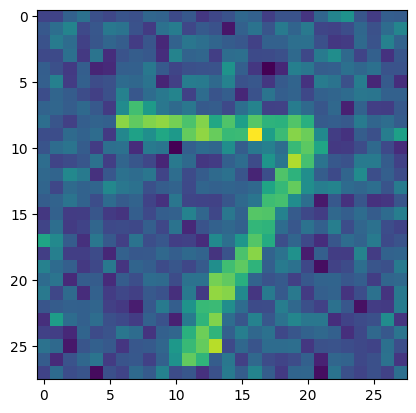

In [17]:
n = 0   # Seleccionar la imagen que se desea comparar

print("Imagen original")
plt.imshow(X_prueba[n]);
plt.show()
print("Imagen ruidosa")
plt.imshow(ruidosas[n]);

Ver otra...otro valor de n

### Crear autocodificador para eliminación de ruido y entrenarlo.

In [18]:
import tensorflow as tf
import numpy as np

La siguiente celda es opcional, se usa para tener reproducibilidad

In [19]:
tf.random.set_seed(101)
np.random.seed(101)

Se usará el mismo autocodificador, solo que con una capa más para introducir el ruido a las imágenes,  en el codificador

In [20]:
codificador = Sequential()
codificador.add(Flatten(input_shape = [28, 28]))

# Agregar ruido a las imágenes
codificador.add(GaussianNoise(0.2))

codificador.add(Dense(400, activation = "relu"))
codificador.add(Dense(200, activation = "relu"))
codificador.add(Dense(100, activation = "relu"))
codificador.add(Dense(50, activation = "relu"))
codificador.add(Dense(25, activation = "relu"))

In [21]:
decodificador = Sequential()
decodificador.add(Dense(50, input_shape = [25],
                        activation = 'relu'))
decodificador.add(Dense(100, activation = 'relu'))
decodificador.add(Dense(200, activation = 'relu'))
decodificador.add(Dense(400, activation = 'relu'))
decodificador.add(Dense(784, activation = "sigmoid"))
decodificador.add(Reshape([28, 28]))

### Conformar el Autocodificador

In [22]:
eliminador_ruido = Sequential([codificador, 
                               decodificador])

In [23]:
eliminador_ruido.compile(loss = "binary_crossentropy", 
                         optimizer = 'adam', 
                         metrics = ['accuracy'])

In [24]:
eliminador_ruido.fit(X_entreno, X_entreno, 
                     epochs = 8,
                     validation_data = [X_prueba, X_prueba])

Epoch 1/8
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1795 - accuracy: 0.1736 - val_loss: 0.1454 - val_accuracy: 0.2167
Epoch 2/8
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1387 - accuracy: 0.2231 - val_loss: 0.1276 - val_accuracy: 0.2352
Epoch 3/8
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1267 - accuracy: 0.2382 - val_loss: 0.1200 - val_accuracy: 0.2490
Epoch 4/8
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1213 - accuracy: 0.2464 - val_loss: 0.1158 - val_accuracy: 0.2534
Epoch 5/8
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1174 - accuracy: 0.2525 - val_loss: 0.1129 - val_accuracy: 0.2524
Epoch 6/8
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1143 - accuracy: 0.2569 - val_loss: 0.1098 - val_accuracy: 0.2609
Epoch 7/8
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1120 - accuracy: 0.2612 - val_loss: 0.1088 - val_accuracy

### Ver resultados con una muestra de las imágenes

In [25]:
diez_imags_con_ruido = muestra(X_prueba[: 10], 
                                 training = True)
limpias = eliminador_ruido(diez_imags_con_ruido[: 10])

**OJO!!!**  Nótese que en la celda anterior, realmente se ha "duplicado" la cantidad de ruido:  una vez por generar imágenes con ruido (primera instrucción), y una segunda vez por pasarlo por el codificador! 

La Original


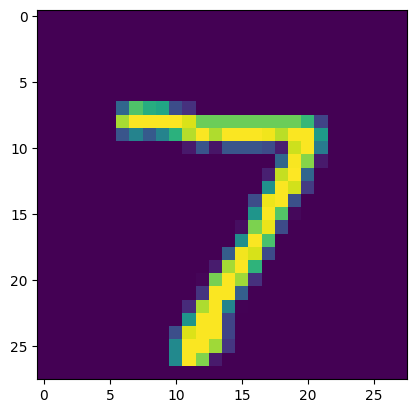

La version con ruido


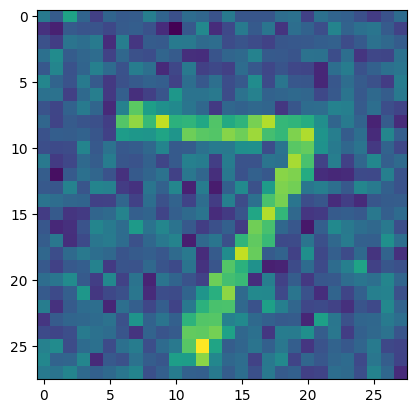

Luego de pasar por el eliminidador de ruido


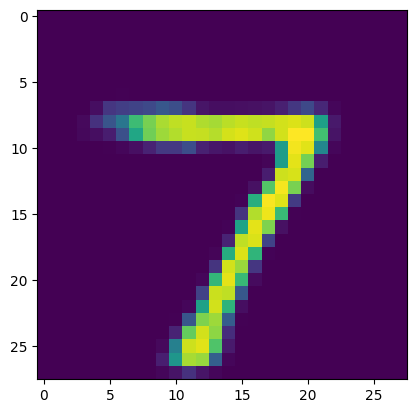

In [26]:
n = 0
print("La Original")
plt.imshow(X_prueba[n])
plt.show()
print("La version con ruido")
plt.imshow(diez_imags_con_ruido[n])
plt.show()
print("Luego de pasar por el eliminidador de ruido")
plt.imshow(limpias[n])
plt.show()